# Recurrent Neural Networks with TensorFlow

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import random
import time
import functools
import tensorflow as tf
from addutils import css_notebook
css_notebook()

In [3]:
from bokeh.layouts import gridplot
import bokeh.plotting as bk
from bokeh.models import Range1d
bk.output_notebook()

Loading BokehJS ...

In [4]:
tools = 'pan,wheel_zoom,box_zoom,reset,save'

## 1 Recurrent Neural Networks

In general ML models are stateless, they see a point in space and decide the output of the model based on the features of that single point. If we use a Multi Layer Perceptron (MLP) for example, we must provide it with **lagged values** in order to force it to take into account past history. Lagged values are portions of past history provided as a set of features to the algorithm. For example if we consider the past 3 values of a temperature to be meaningful for the algorithm we can reshape the dataset such that the feature at time t are the values of temperature at time t-1, t-2, t-3.The use of lagged values, however, poses two kind of problems. The choice of the number of past values to include is domain specific and it could be different for each feature (for example a feature needs 3 lagged values while another needs more); it is thus another hyperparameter to tune. Moreover using many lagged values increases the dimensionality of the problem and consequently the difficulty to find a model with desired accuracy.

In practice one limitation of Neural Networks (and Convolutional Neural Networks as well) is that they accept a fixed size input (for instance an image) and they output a fixed size vector (the class that the image belongs to). Moreover they perform the computation for only a fixed number of steps, that is the number of layers that they are composed of. 

For these reasons we use a different model of neural networks with loops that allows information of past values to persist inside the nodes. This kind of networks are called **Recurrent Neural Network (RNN)** and they are particularly useful for modeling and generating sequences. They take time into account and they doesn't need to be manually fed with lagged values. One can think of a RNN as the same neural network that receive values from its predecessor.

Recurrent Neural Networks operates on sequences of vectors and produce sequences of vectors. 

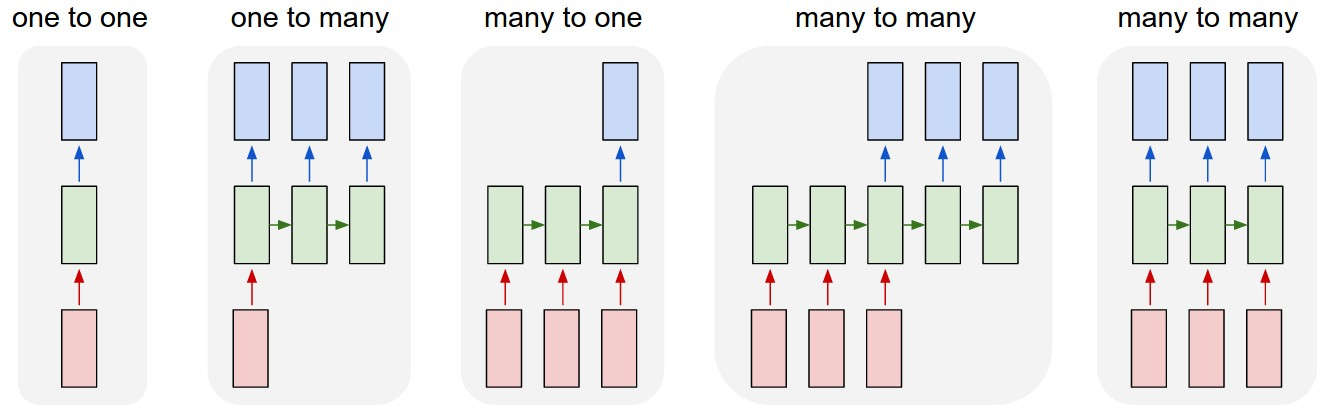

In [5]:
Image("images/diags.jpeg", width=700, height=700)

Each rectangle is a vector and arrows represent functions. Input vectors are in red, output vectors are in blue and green vectors hold the RNN's state. From left to right: (1) Vanilla mode of processing without RNN, from fixed-sized input to fixed-sized output (e.g. image classification). (2) Sequence output (e.g. image captioning takes an image and outputs a sentence of words). (3) Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment). (4) Sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in French). (5) Synced sequence input and output (e.g. video classification where we wish to label each frame of the video). Notice that in every case are no pre-specified constraints on the lengths sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like. 

RNNs combine the input vector with their state vector with a fixed function to produce a new state vector. The function is learned and can be interpreted as running a program with a set of inputs and internal variables. They can be viewed as programs in some sense, and as a matter of fact they are Turing-Complete (in the sense that they can simulate arbitrary programs). 

One of the most intriguing features of RNN is that they potentially recover dependencies of the current value from past data. Sometimes RNNs need only recent information to recover the present, however if we need more context to recover the present, that is, the gap between the relevant information and the point were it is important is high, RNNs become unable to learn. Let's look at an RNN in more details. In the picture below we can see a simple RNN with a single input, output and recurrent unit.

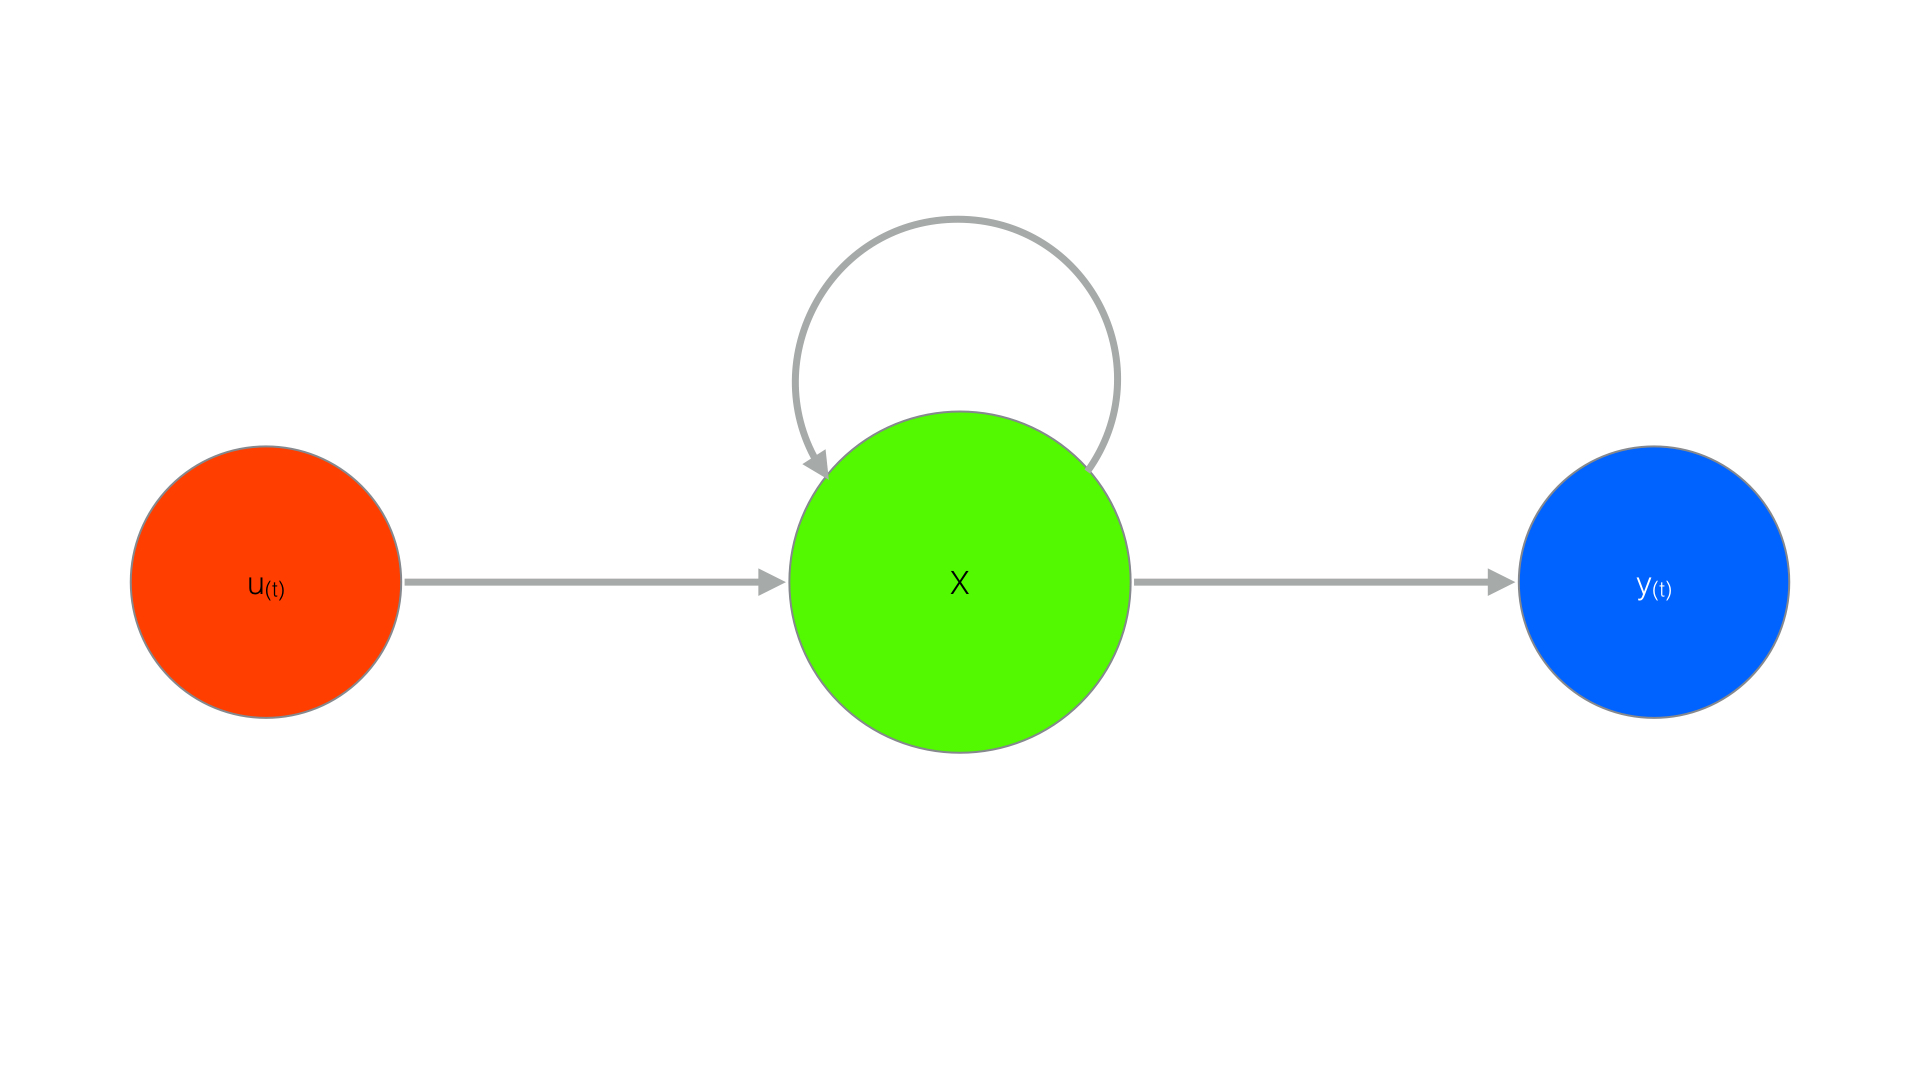

In [6]:
Image("images/simpleRNN.jpeg", width=400, height=400)

If we unroll the network it as in picture below, the RNN looks like a series of copy of the same simple NN unit. Each copy receives the input from the previous. We can see that inputs travel accross time; past input (blue node) is related to current input (red node). However if the weight is less than one, as we travel along each time steps the effect of the input (blue node) diminishes as a function of the time interval between the two. On the contrary if the weight is greater than one the output will explode.

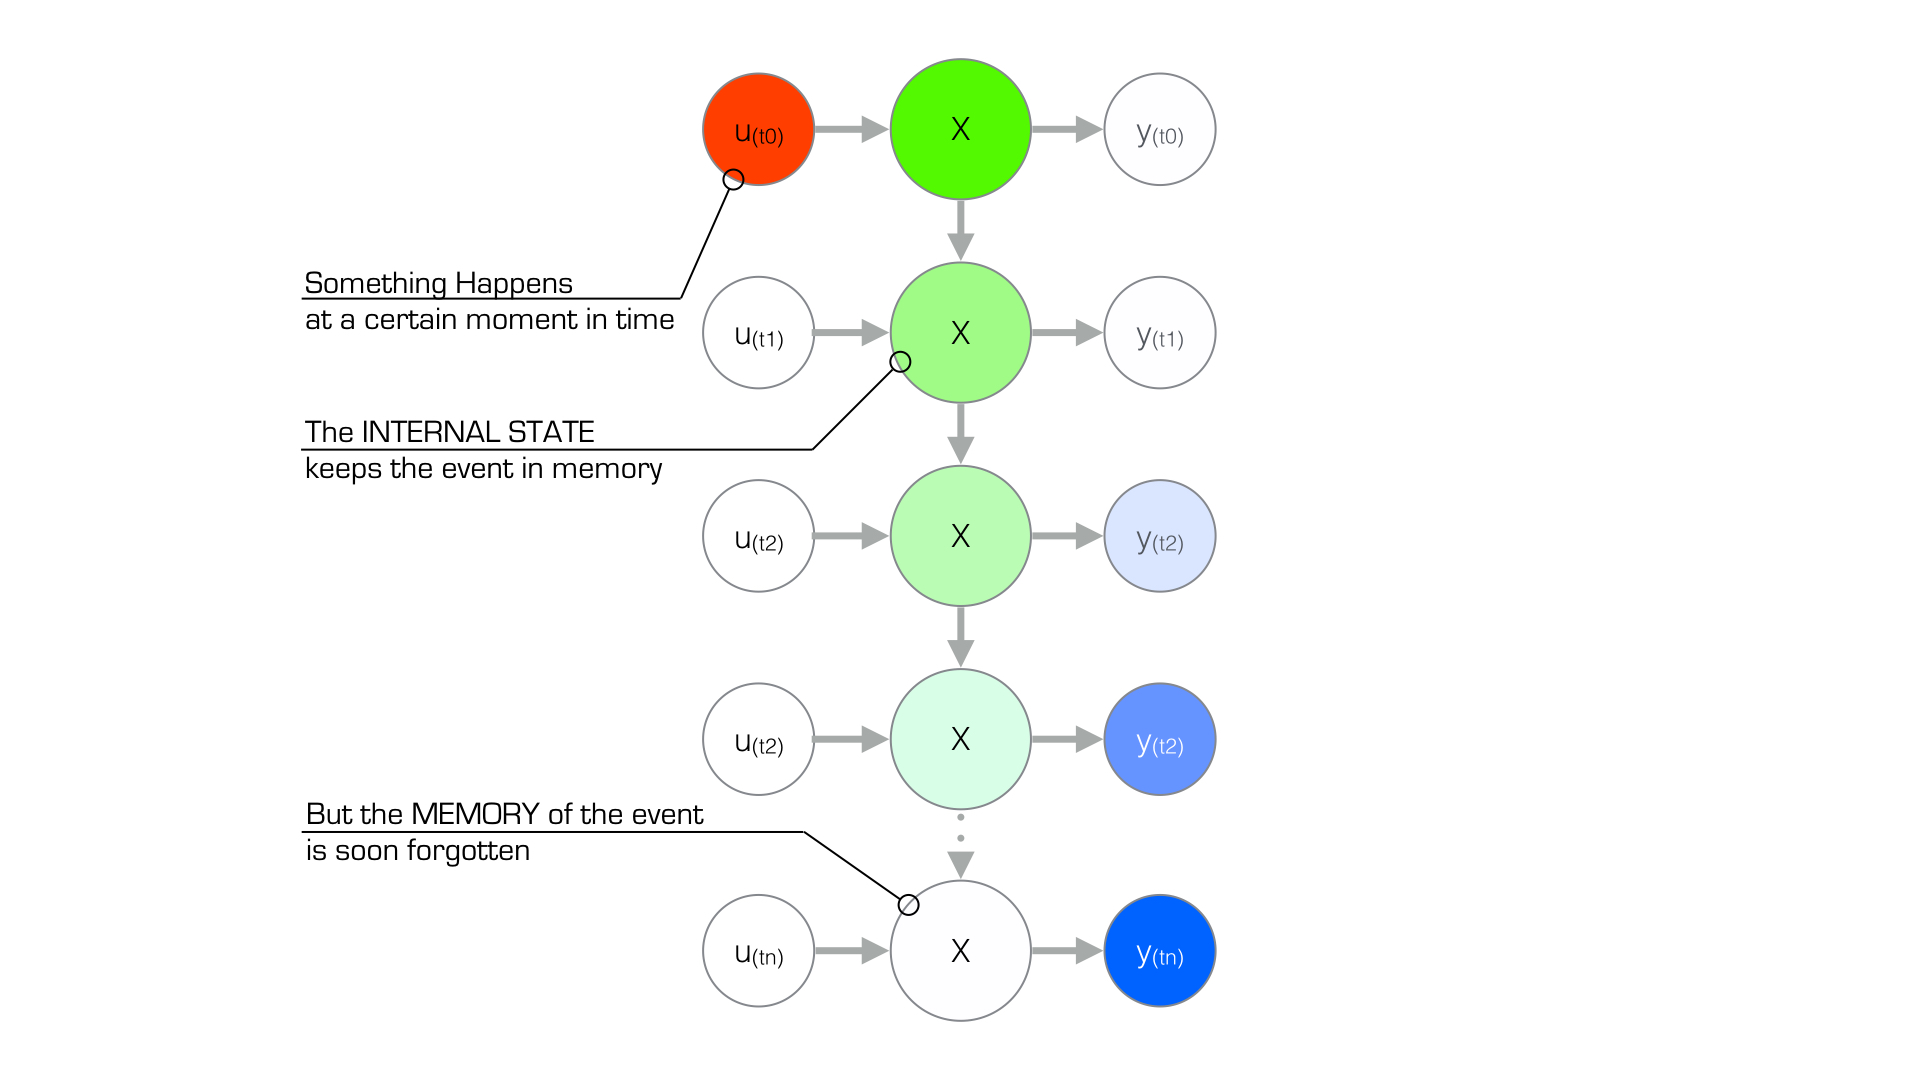

In [7]:
Image("images/unrolledRNN.jpeg", width=600, height=600)

These problems are referred to as **vanishing** and **exploding gradient** and they are a serious problem in training recurrent neural networks. One of the most successful RNN architecture that overcome the problem is LSTM. We will explain how it works in next section

How is the network trained? With **Backpropagation Through Time**, especially with its **Truncated** variant.

In [9]:
Image("images/RNN_true_truncated_backprop.png", width=600, height=600)

### 1.2 LSTM

Long Short Term Memory networks (LSTMs) are a special kind of RNN, capable of learning long-term dependencies. They were introduced by [Hochreiter & Schmidhuber (1997)](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf) and successively developed with many variants.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is their default behavior.

In the next picture we can see the architecture of an LSTM cell and we will explain how it works in detail. For further details you can look at this wonderful [blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

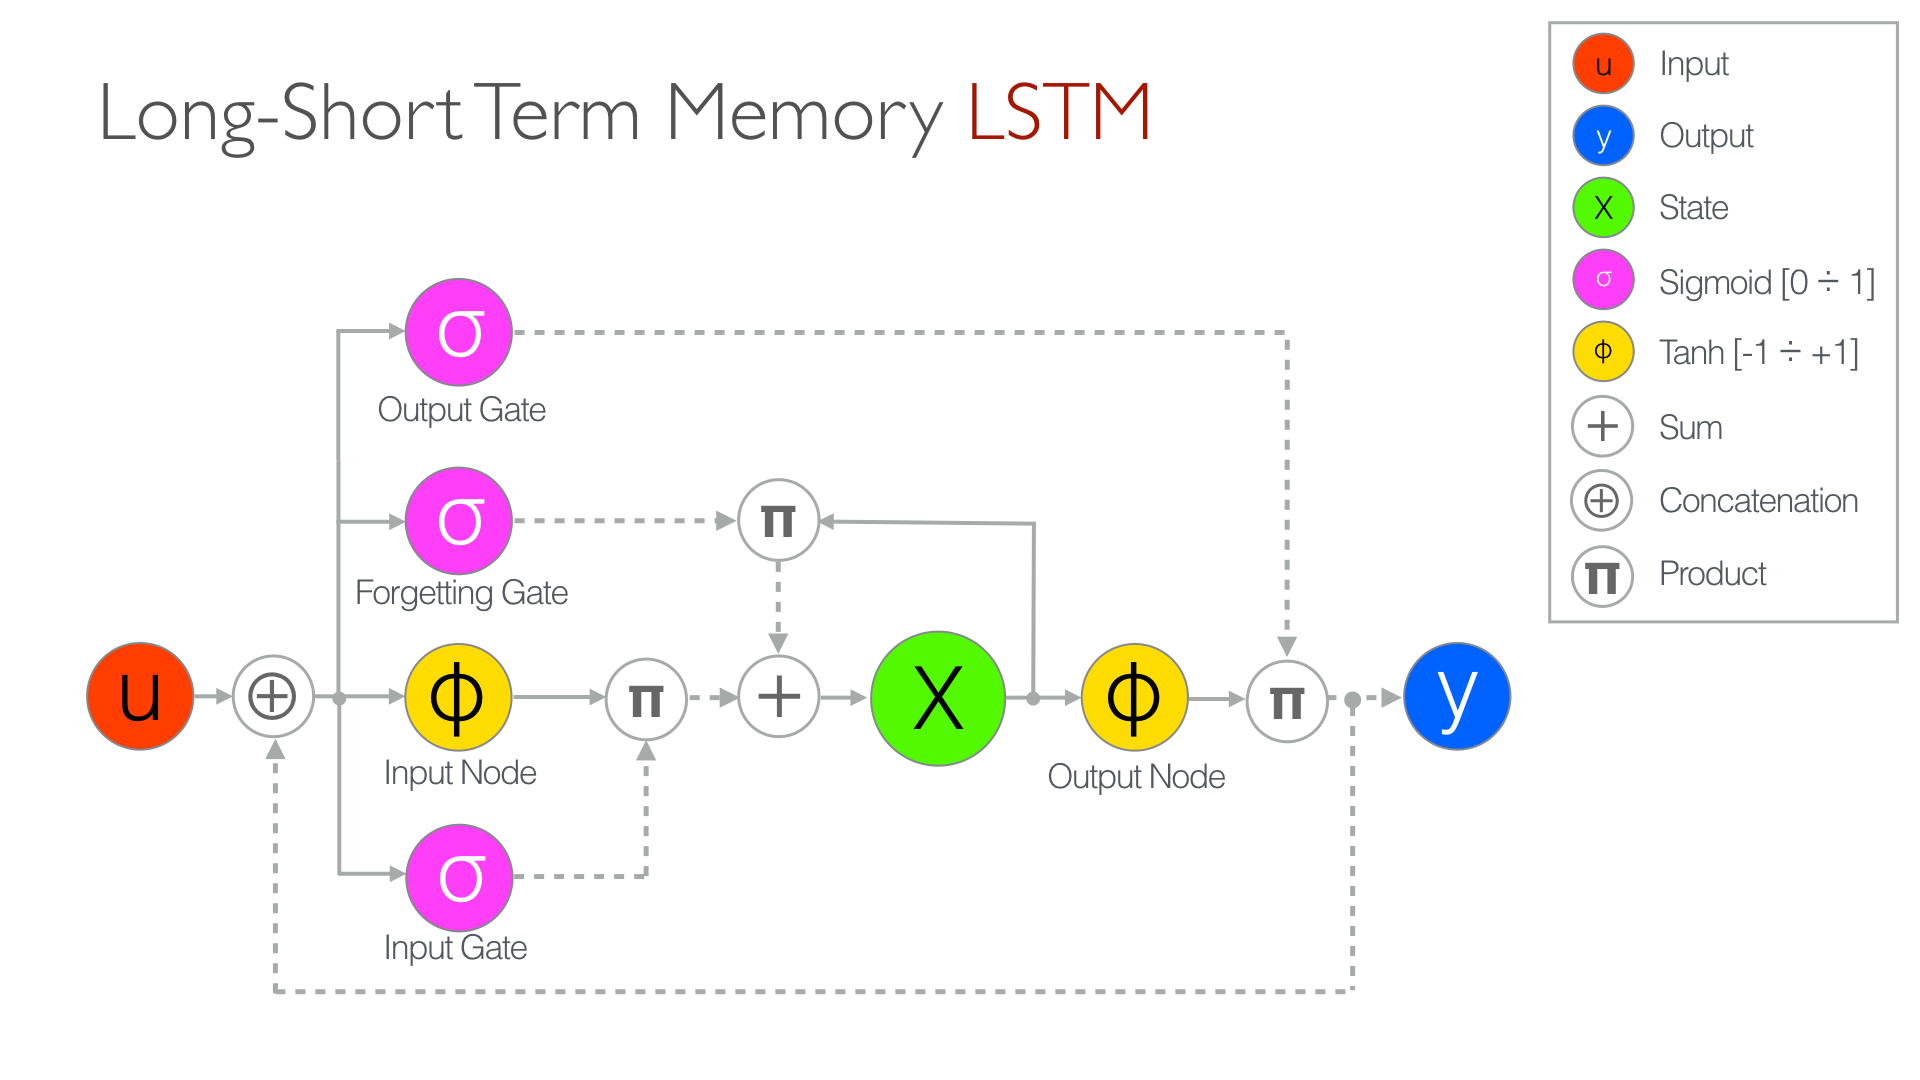

In [10]:
Image("images/LSTM.001.jpeg", width=700, height=700)

In practice while we refer to an LSTM as a "cell" internally it is composed of four neural layers that interact to provide the LSTM's distinctive features.

LSTM networks looks like ordinary RNN, but they have an **internal state** (c) that has a self-connected recurrent edge with weight 1. This edge spans adjacents time steps, ensuring that error can pass through time steps without vanishing or exploding. This is sometimes referred to as **constant error carousel (CEC)**

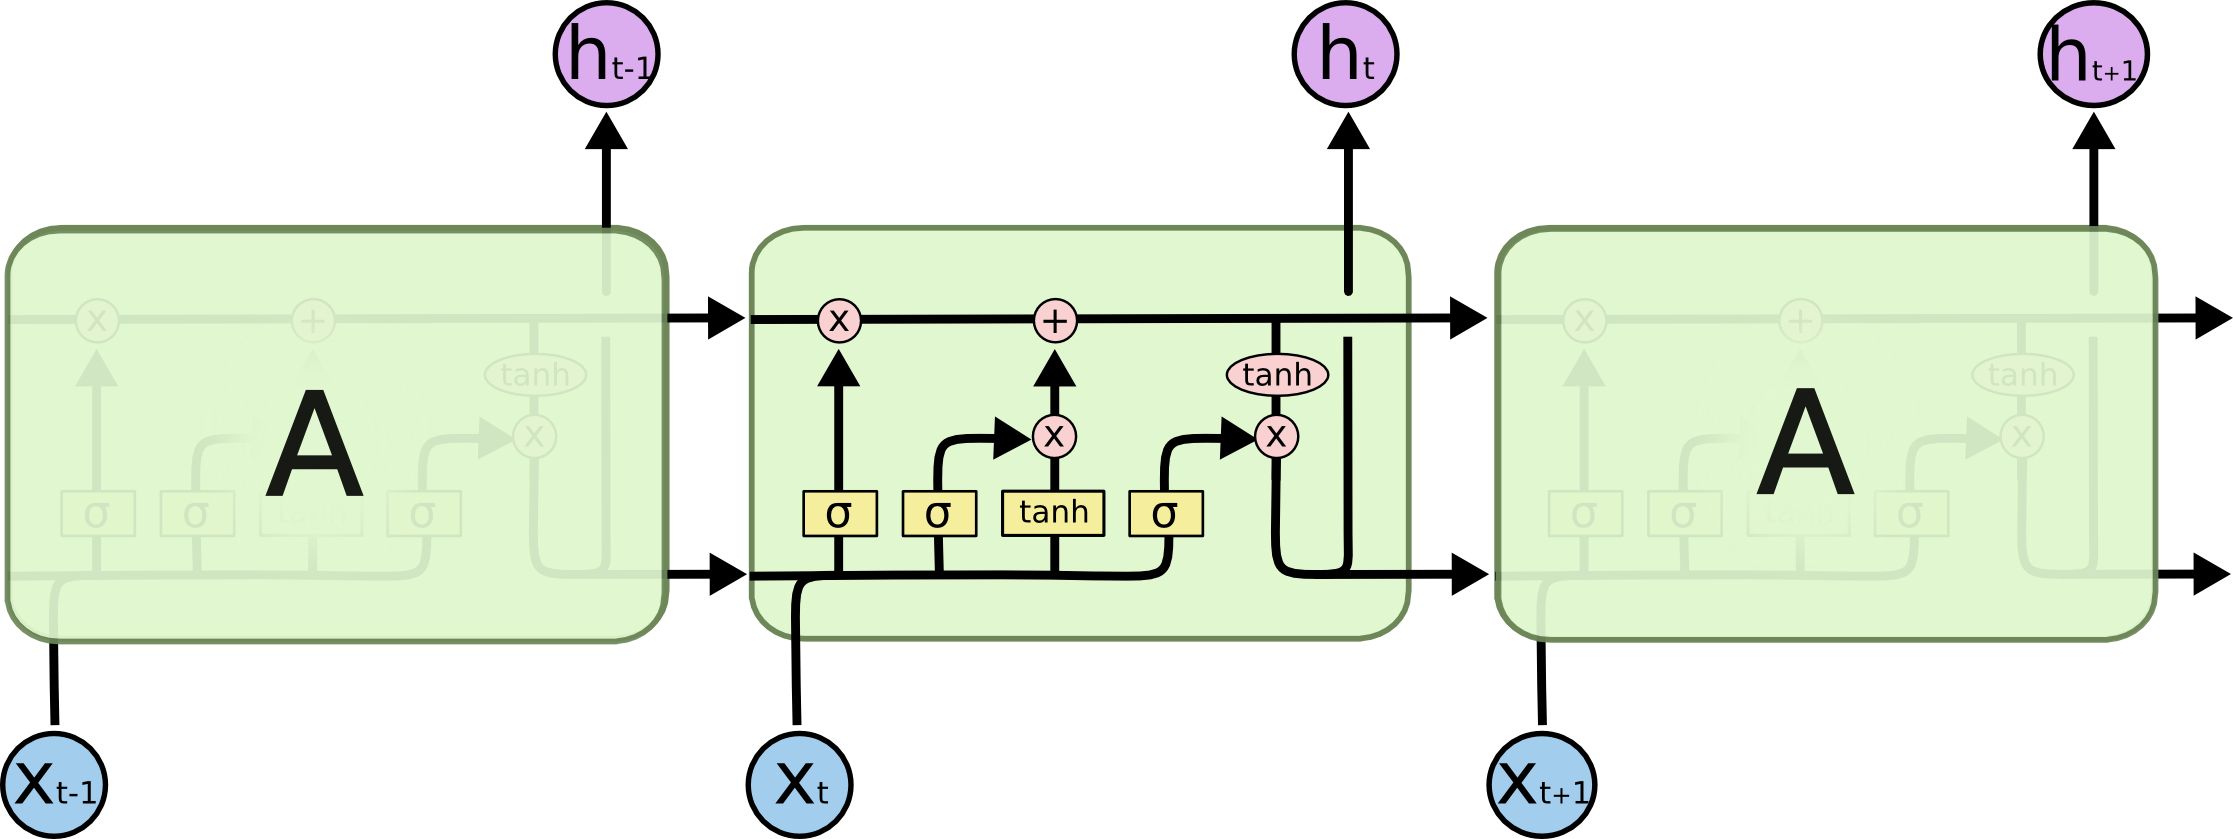

In [11]:
Image("images/LSTM3-chain.png", width=600, height=600)

The LSTM have the ability to **remove or add information to the cell state**, with the so  called gates, that control how the flux of information passes through the network and persist in the internal state. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation. The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through. In practice saturation regime allow or deny access to the CEC. A value of zero means deny access while a value of one means allow access, to the CEC.

The input gate controls how information enter the system (modifying the internal state) and it is combined with input node. Output gate controls how the internal state affects the output. Finally the forget gate controls how past values of internal states are combined with the result from input gate and input node. All gates and node take as input the concatenation of current input and past network output. In practice one can think of these gates as binary gates that controls whether each memory cell is updated, whether is reset to zero and whether is local state is injected in the hidden state.

Intuitively in the forward pass LSTM can learn how to get input activation into internal state. If the input gate have 0 value, no input gate activation can enter the system. On the contrary if input gate saturate to 1, input activation modifies internal state. Similarly, the output gate learns when to let values out. When both gates are closed, the internal state is not affected and persists throughout time steps neither increasing nor decreasing. In the backward pass the error can propagate back many steps unchanged (because weight is fixed at 1) neither exploding nor vanishing. The function of the gates is to learn when to let error in or out.

One of the most important features of LSTM is **Uniform Credit Assignment**. Each pattern has the same probability of being discovered. In ordinary Recurrent Neural Networks, because of the vanishing gradient, only the most recent pattern can be discovered.

### 1.3 TensforFlow implementation

In this section we describe the **implementation details of the TensorFlow model.** 

This is an helper function that allows us to access the element of a dictionary as if they were parameters.

In [ ]:
class AttrDict(dict):
    def __getattr__(self, key):
        if key not in self:
            raise AttributeError
        return self[key]

    def __setattr__(self, key, value):
        if key not in self:
            raise AttributeError
        self[key] = value

The TensorFlow code defines a compute graph rather than performing actual computations. If we want to structure our models in classes, we cannot directly expose its outputs from functions or properties, since this would add new operations to the graph every time.

Using an instance of this from the outside creates a new computation path in the graph when we access model.optimize, for example. Moreover, this internally calls model.prediction creating new weights and biases. To address this design problem, we introduce the following @lazy_property decorator.

The idea is to define a property that is only evaluated once. The result is stored in a member called like the function with some prefix, for example _lazy_ here. Subsequent calls to the property name then return the existing node of of the graph

In [ ]:
def lazy_property(function):
    attribute = '_lazy_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper

The following class implements a Sequence Prediction Model in TensorFlow. It is used as a masking object in order to reuse it as we will for two different models.

First, we obtain the lengths of sequences in the current data batch. 

For the prediction, we define an RNN as usual. However, this time we want to augment it by stacking a linear layer ontop of its last activation. For the RNN, we use a cell type and cell count defined in the params object. We use the already defined length property to only show rows of the batch to the RNN up to their length. We can then fetch the last output activation of each sequence and feed that into a softmax layer. Defining the softmax layer should be pretty straight forward if you’ve followed the book up to this section.

As of now, TensorFlow only supports indexing along the first dimension, using tf.gather(). We thus flatten the first two dimensions of the output activations from their shape of sequences x time_steps x features and construct an index into this resulting tensor. The index takes into account the start indices for each sequence in the flat tensor and adds the sequence length to it. Actually, we only add length - 1 so that we select the last valid time step.

In [ ]:
class SequencePredictionModel:
    def __init__(self, data, target, params):
        self.data = data
        self.target = target
        self.params = params
        self.state
        self.prediction
        self.cost
        self.error
        self.optimize

    @lazy_property
    def length(self):
        used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
        length = tf.reduce_sum(used, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        return length

    @lazy_property
    def prediction(self):
        prediction, _ = self.forward
        return prediction

    @lazy_property
    def state(self):
        _, state = self.forward
        return state

    @lazy_property
    def forward(self):
        stacked_lstm = tf.contrib.rnn.MultiRNNCell([self.params.rnn_cell(self.params.rnn_hidden)],
                                                   state_is_tuple=True)

        output, state = tf.nn.dynamic_rnn(
            stacked_lstm,
            self.data,
            dtype=tf.float32,
            sequence_length=self.length,
        )
        last = self._last_relevant(output, self.length)

        with tf.variable_scope('linear_regression'):
            dtype = last.dtype.base_dtype

            target_shape = self.target.get_shape()
            if len(target_shape) == 1:
                output_shape = 1
                self.target = tf.reshape(self.target, [-1, 1])
            else:
                output_shape = target_shape[1]

            init = tf.random_normal_initializer(0, 0.1, dtype=dtype)

            weights = tf.get_variable('weights', [last.get_shape()[1], output_shape],
                                      initializer=init,
                                      dtype=dtype)
            bias = tf.get_variable('bias', [output_shape],
                                   initializer=init,
                                   dtype=dtype)

            prediction = tf.nn.xw_plus_b(last, weights, bias)

        return prediction, state

    @lazy_property
    def cost(self):
        loss = tf.reduce_mean(tf.square(tf.subtract(self.target, self.prediction)))
        return loss

    @lazy_property
    def error(self):
        return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.target, self.prediction))))

    @lazy_property
    def optimize(self):
        train_op = self.params.optimizer.minimize(self.cost, global_step=tf.contrib.framework.get_global_step())
        return train_op

    @staticmethod
    def _last_relevant(output, length):
        batch_size = tf.shape(output)[0]
        max_length = int(output.get_shape()[1])
        output_size = int(output.get_shape()[2])
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(output, [-1, output_size])
        relevant = tf.gather(flat, index)
        return relevant

You may have noticed that Tensorflow contains two different functions for RNNs: tf.nn.rnn and tf.nn.dynamic_rnn. Which one to use?

Internally, tf.nn.rnn creates an unrolled graph for a fixed RNN length. That means, if you call tf.nn.rnn with inputs having 200 time steps you are creating a static graph with 200 RNN steps and graph creation is slow.

`tf.nn.dynamic_rnn` solves this. It uses a tf.While loop to dynamically construct the graph when it is executed. That means graph creation is faster and you can feed batches of variable size. What about performance? You may think the static rnn is faster than its dynamic counterpart because it pre-builds the graph. In my experience that’s not the case.

In short, just use tf.nn.dynamic_rnn. There is no benefit to tf.nn.rnn and I wouldn’t be surprised if it was deprecated in the future.

The `preprocess_batched` function simply returns one batch at the time until the dataset is finished

In [ ]:
def preprocess_batched(X, y, batch_size):
    num_batches = X.shape[0] // batch_size
    last = X.shape[0] % batch_size
    for i in range(num_batches):
        index = i * batch_size
        yield X[index:index+batch_size], y[index:index+batch_size]
    if last:
        index = (i+1) * batch_size
        yield X[index:index+last], y[index:index+last]

We use this function to construct the dataset in the manner required by TensorFlow RNN api, with dimension [batch_size, length, features]

In [ ]:
def rolling_past(X, y, size):
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    dfs = [X.shift(i) for i in range(size)]
    res = pd.concat(dfs, axis=1)
    res['target'] = y
    res.dropna(inplace=True, axis=0)
    res_shuffle = res.iloc[np.random.permutation(len(res))]
    res_y = res['target']
    res.drop(['target'], axis=1, inplace=True)
    res_y_shuffle = res_shuffle['target']
    res_shuffle.drop(['target'], axis=1, inplace=True)
    return (res.values.reshape(res.shape[0], size, -1), res_y.values.reshape((-1, 1)),
            res_shuffle.values.reshape(res_shuffle.shape[0], size, -1), res_y_shuffle.values.reshape((-1,1)))

In [ ]:
Image("images/dataset.jpg", width=600, height=600)

### 1.4 Vertical displacement of the wheels of a one dimensional car

A car is running along a road with speed v(t). A sensor is installed at the front wheel to measure the vertical displacement Hi(t) of the front wheel caused by the road profile. If the wheels and road never lose contact, then the vertical displacement of the rear wheel, Ho(t), can be seen as a variable transport delay of Hi(t), which is  determined by the length L between the two wheels and the speed v(t).

We define the hyperparameters to use.

In [ ]:
TIMESTEPS_BUMPY = 25
BATCH_SIZE_BUMPY = 128
HIDDEN_BUMPY = 128
LEARNING_BUMPY = 0.001
EPOCHS_BUMPY = 100

In [ ]:
bumpy_params = AttrDict(
    rnn_cell=tf.contrib.rnn.LSTMCell,
    rnn_hidden=HIDDEN_BUMPY,
    optimizer=tf.train.RMSPropOptimizer(learning_rate=LEARNING_BUMPY, decay=0.9),
)

In [ ]:
X = pd.read_csv('example_data/bumpy_road.csv')
y = X['RearTireDisplacement'].copy()
X.drop(['RearTireDisplacement', 'Delay'], inplace=True, axis=1)

X, y, X_shuffle, y_shuffle = rolling_past(X, y, TIMESTEPS_BUMPY)
print(X.shape, y.shape)

In [ ]:
tf.reset_default_graph()
data = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2]])
target = tf.placeholder(tf.float32, [None, y.shape[-1]])
model = SequencePredictionModel(data, target, bumpy_params)

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
n_batches = X.shape[0] // BATCH_SIZE_BUMPY
print('Start training')
t0 = time.time()
for i in range(EPOCHS_BUMPY):
    batches = preprocess_batched(X_shuffle, y_shuffle, BATCH_SIZE_BUMPY)
    for index, batch in enumerate(batches):
        feed = {data: batch[0], target: batch[1]}
        error, _ = sess.run([model.error, model.optimize], feed)
        tot_index = i*n_batches + index
        if not tot_index % 100:
            print('{}: {:3.3f}'.format(tot_index + 1, error))
print('Training time: {:3.6f}'.format(time.time()-t0))

In [ ]:
batches = preprocess_batched(X, y, BATCH_SIZE_BUMPY)
y_hat = np.zeros_like(y)
curr = 0
for index, batch in enumerate(batches):
    feed = {data: batch[0]}  # , target: batch[1]}
    prediction, state = sess.run([model.prediction, model.state], feed)
    y_hat[curr:curr+len(prediction)] = prediction
    curr += len(prediction)

In [ ]:
print(y_hat.shape)
print(y.shape)
score = sqrt(mean_squared_error(y, y_hat))
print('Train Score: %.2f RMSE' % (score))

In [ ]:
fig1 = bk.figure(plot_width=800, plot_height=300, tools=tools)
fig1.line(list(range(len(y))), np.ravel(y), legend='target')
fig1.line(list(range(len(y))), np.ravel(y_hat), color='orange', legend='prediction')
left, right = 2000, 2400
fig1.x_range=Range1d(left, right)
ha1 = bk.show(fig1)

## 2 Temperature Forecast

In this section we will focus on constructing a model of a temporal series. Our goal is to predict what value a certain quantity will take few steps in the future. This setting implies the use a regression algorithm to predict the numerical outcome of the temporal series.

The system we are studying is a building and we are trying to predict its internal temperature based on the measurements of a collection of sensors. The temperature itself is recorded by a sensor and its past values are thus available to the model. Other measurements include the status of cooling and heating systems, as well as other environmental quantities. We will use both the temperature and the other exogenous inputs in the model; most of the signal past value will be available, but we can use engineered features such as the ones based on time that we have constructed in previous section. For example, suppose we want to know the value that the temperature will take the next hour. We know all past values of the temperature and the energy of the cooling system and other signals (exogenous inputs) up to now. However we can use future information as well, because we know all future value of our derived feature up to the time of prediction.

We need to construct a model that takes into account the nonlinearity of the system and relates past values to future values of temperature. In order to perform well, the model should see enough past value to predict the temperature but not too much to be misleaded. In general ML models are stateless, they see a point in space and decide the output of the model based on the features of that single point. If we use a Multi Layer Perceptron (MLP) for example, we must provide it with lagged values in order to force it to take into account past history. Lagged values are portions of past history provided as a set of features to the algorithm. For example if we consider the past 3 values of a temperature to be meaningful for the algorithm we can reshape the dataset such that the feature at time t are the values of temperature at time t-1, t-2, t-3. The use of lagged values, however, poses two kind of problems. The choice of the number of past values to include is domain specific and it could be different for each feature (for example a feature needs 3 lagged values while another needs more); it is thus another hyperparameter to tune. Moreover using many lagged values increases the dimensionality of the problem and consequently the difficulty to find a model with desired accuracy.

In [ ]:
data = pd.read_csv('example_data/data2.csv', parse_dates=['X0'])

In [ ]:
prediction = 12
steps_forward = 12
steps_backward = 0 
inputs_default = 0
hidden = 128
batch_size = 1024
timesteps = 12
epochs = 100
test_size = 0.4

## 2.1 Transformation

In ML practice, feature transformation is employed to ease computation of algorithms and improve their accuracy. Deep Learning has the ability to automatically create abstraction of data that resemble the feature transformation process. However in practical engineering applications we found that transforming the features knowing the physiscal mechanisms of the underling process, greatly improve the resulting deep learning or neural network model.

Recall the example of a time series at the beginning of the notebook. **Forecasting a physical value over time, could make use of future reference to known quantities.** For example we know what day will be the next three days from now. **If our value has a cyclic behavior it is possible to take advantage of this knowledge and transform the time in a feature that we know in advance.** Moreover in our example the temperature is related to the time of the day and the period of the year in a cyclic fashion (we know that in a mid afternoon of a summer day the temperature is likely high!)

In [ ]:
dayofweek = [o.dayofweek for o in data['X0']]
weekofyear = [o.week for o in data['X0']]
dayofyear = np.array([o.dayofyear for o in data['X0']])
dycos = -np.cos((dayofyear / 366.0) * 2 * np.pi)
minuteofday = np.array([o.minute + (o.hour * 60) for o in data['X0']])
mdcos = -np.cos((minuteofday / (24.0 * 60)) * 2 * np.pi)

In [ ]:
fig1 = bk.figure(plot_width=800, plot_height=200, x_axis_type='datetime', tools=tools)
fig1.line(data['X0'], dycos)
fig2 = bk.figure(plot_width=800, plot_height=200, x_axis_type='datetime', x_range=fig1.x_range, tools=tools)
fig2.line(data['X0'], mdcos)
ha1 = bk.show(gridplot([[fig1], [fig2]]))

As suggested at the beginning of this section it is possible to use future values of some features. In this case we can take advantage of this information and use lagged future values as with MLP. In practice the vector of regressors is extended with future values of some feature. Let's say we have feature *X1, X2, X3, X4* at time *t*. For some reason feature X4 can be determined for future values, so our new input a time t will be *X1, X2, X3, X4, X4(t+1), X4(t+2), X4(t+3), ...* and so forth. 

In [ ]:
Image("images/lagged.jpeg", width=500, height=500)

With the code below it is possible to specify the number of **steps forward** we want added to the inputs datasets. We choose to have a number of steps equal the number of future steps we want to predict.

In [ ]:
input_range = {
    'X109': [steps_backward, steps_forward],
    'X110': [steps_backward, steps_forward],
    'X111': [steps_backward, steps_forward],
    'X112': [steps_backward, steps_forward],
    'X70': [steps_backward, steps_forward],
    'X71': [steps_backward, steps_forward],
    'X73': [steps_backward, steps_forward],
    'X91': [steps_backward, steps_forward],
    'X92': [steps_backward, steps_forward],
    'X94': [steps_backward, steps_forward],
}

In the following code we choose the subset of columns that we want in the dataset, and the column that represent the target value.

In [ ]:
X_columns = ['X109',  'X54', 'X53', 'X71', 'X112', 'X59', 'X111', 'X92', 'X66', 
             'X94', 'X73', 'X91', 'X110', 'X40', 'y', 'X47', 'X48', 'X70', 'X60']
y_column = 'y'

The following two functions generate the two main datasets. The first function creates X and y. In particular it shift the traget by the number of steps specified in prediction variable. This operation could be helpful to predict future values, where the prediction horizon is many steps ahead. The second function split the dataset in training and validation. The dataset is scaled to have zero mean and unit variance, otherwise the Network could be stuck in local minima during training. It is worth noting that using future values it is not strictly necessary, but sometimes it helps the model to have better accuracy. This can be seen as another parameter to set.

In [ ]:
def transform(source, y_column, X_columns, inputs_per_column,
              inputs_default, steps_forward, dates='X0'):
    dates = source[dates].iloc[:-steps_forward]

    y = pd.DataFrame()
    y[y_column] = source[y_column].shift(-steps_forward)

    scaler = StandardScaler()

    new_X = pd.DataFrame(scaler.fit_transform(source[X_columns]), columns=X_columns)
    X = pd.DataFrame()

    for column in X_columns:
        if inputs_per_column:
            inputs = inputs_per_column.get(column, None)
            if inputs:
                inputs_list = range(inputs[0], inputs[1] + 1)
            else:
                inputs_list = range(-inputs_default, 1)
        else:
            inputs_list = range(-inputs_default, 1)

        for i in inputs_list:
            col_name = "%s_%s" % (column, i)
            X[col_name] = new_X[column].shift(-i)  # Note: shift direction is inverted

    null_indices = y.isnull().any(1).nonzero()[0]
    X.drop(null_indices, axis=0, inplace=True)
    X.dropna(inplace=True, axis=0)
    y.dropna(inplace=True, axis=0)

    return X, y, dates, X.index

In [ ]:
def split(X, y, dates, test_size):
    X.set_index(dates, inplace=True)
    X_group = X.groupby(X.index.week)
    y.set_index(dates, inplace=True)
    y_group = y.groupby(X.index.week)

    a = list(X_group.groups.keys())# [:-1] 
    random.shuffle(a)
    sp = int(len(a) * test_size)
    # train_weeks = sorted(a[sp:])
    train_weeks = a[sp:]
    # test_weeks = sorted(a[:sp])
    test_weeks = a[:sp]

    print('train_weeks: ', train_weeks)

    X_train = pd.concat([X_group.get_group(i).reset_index(drop=True) for i in train_weeks])
    X_test = pd.concat([X_group.get_group(i).reset_index(drop=True) for i in test_weeks])
    y_train = pd.concat([y_group.get_group(i).reset_index(drop=True) for i in train_weeks])
    y_test = pd.concat([y_group.get_group(i).reset_index(drop=True) for i in test_weeks])

    return (X_train.values, y_train.values, X_test.values, y_test.values)

In [ ]:
X, y, dates, _ = transform(source=data, y_column=y_column, X_columns=X_columns,
                           inputs_per_column=input_range, inputs_default=inputs_default,
                           steps_forward=steps_forward)

In [ ]:
X_train, y_train, X_test, y_test = split(X, y, dates, test_size)

In [ ]:
X_train = X_train.astype(np.float32).copy()
y_train = y_train.astype(np.float32).copy()
X_test = X_test.astype(np.float32).copy()
y_test = y_test.astype(np.float32).copy()
X, y = X.values.astype(np.float32), y.values.astype(np.float32)

X_train, y_train, X_train_shuffled, y_train_shuffled = rolling_past(X_train, y_train, timesteps)
X_test, y_test, X_test_shuffled, y_test_shuffled = rolling_past(X_test, y_test, timesteps)
X, y, _, _ = rolling_past(X, y, timesteps)

Now the dataset and the target are in the form of *numpy* arrays and they are further split in training and test sets. Not all TensorFlow operations support float64 format so we convert all variables to type float32

In [ ]:
params = AttrDict(
    rnn_cell=tf.contrib.rnn.LSTMCell,
    rnn_hidden=hidden,
    optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001, decay=0.9),
)

In [ ]:
tf.reset_default_graph()
data = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2]])
target = tf.placeholder(tf.float32, [None, y.shape[-1]])
model = SequencePredictionModel(data, target, params)

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Now we can train the model.

In [ ]:
n_batches = X.shape[0] // batch_size
print('Start training')
t0 = time.time()
for i in range(epochs):
    batches = preprocess_batched(X_train_shuffled, y_train_shuffled, batch_size)
    for index, batch in enumerate(batches):
        feed = {data: batch[0], target: batch[1]}
        error, _ = sess.run([model.error, model.optimize], feed)
        tot_index = i*n_batches + index
        if not tot_index % 100:
            print('{}: {:3.3f}'.format(tot_index + 1, error))
print('Training time: {:3.6f}'.format(time.time()-t0))

And last we predict the output for the training set and test set.

In [ ]:
batches = preprocess_batched(X, y, batch_size)
y_hat = np.zeros_like(y)
curr = 0
for index, batch in enumerate(batches):
    feed = {data: batch[0]}  # , target: batch[1]}
    prediction, state = sess.run([model.prediction, model.state], feed)
    y_hat[curr:curr+len(prediction)] = prediction
    curr += len(prediction)

In [ ]:
batches = preprocess_batched(X_train, y_train, batch_size)
y_train_predicted = np.zeros_like(y_train)
curr = 0
for index, batch in enumerate(batches):
    feed = {data: batch[0]}  # , target: batch[1]}
    prediction = sess.run([model.prediction], feed)
    y_train_predicted[curr:curr+len(prediction[0])] = prediction[0]
    curr += len(prediction[0])

In [ ]:
batches = preprocess_batched(X_test, y_test, batch_size)
y_test_predicted = np.zeros_like(y_test)
curr = 0
for index, batch in enumerate(batches):
    feed = {data: batch[0]}  # , target: batch[1]}
    prediction = sess.run([model.prediction], feed)
    y_test_predicted[curr:curr+len(prediction[0])] = prediction[0]
    curr += len(prediction[0])

In [ ]:
trainScore = sqrt(mean_squared_error(y_train, y_train_predicted))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(y_test, y_test_predicted))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
fig_b = bk.figure(plot_width=800, plot_height=350, 
                  x_axis_label='time',
                  y_axis_label='value',
                  tools=tools)
fig_b.line(range(len(y)), np.ravel(y), legend='true value')
fig_b.line(range(len(y_hat)), np.ravel(y_hat), color='orange', legend='predicted value')
left, right = 5000, 10000
fig_b.x_range=Range1d(left, right)
bk.show(fig_b)

The graph above depicts the true value (blue line) against the predicted value (orange line); as can be seen the orange line follows the blue line closely and the error is quite low. However it is possible to improve the model, for example if the train error is too low compared to the test error, it could be helpful include a form of regularization inside the model.

## References

1. [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.